# **Binary Image Classification Using Convolutional Neural Networks**

This notebook implements a model based on [convolutional neural networks (CNN)](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) for binary image classification using the [Cats Vs Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) dataset. The dataset contains 25,000 RGB images of cats and dogs (23,262 excluding corrupted images) and is loaded using TensorFlow Datasets. Since the dataset only includes a training set, it is split into 80% for training and 20% for testing, ensuring a balanced representation of both classes, cats and dogs, in each set. Additionally, the trained model is also evaluated using the [Oxford-IIIT Pet](https://www.robots.ox.ac.uk/%7Evgg/data/pets/) dataset, which contains RGB images of dogs and cats distributed across 37 classes, but for this purpose, only the two superclasses (species), ``Cats`` and ``Dogs``, are considered.

Better results are achieved in the notebook [BinaryImageClassification_ViT_CatsVsDogs](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/VisionTransformerModels/ImageClassification_ViT_CatsVsDogs.ipynb), where an accuracy of **99.72%** is reached on the test dataset.



## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 100
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

## **Prepare the dataset for training**

### **Load the dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [ ]:
len(train_dataset), len(test_dataset)

(18610, 4652)

In [ ]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
class_names = [name.capitalize() for name in class_names]

print("Number of classes:", num_classes)
print("Class names:", class_names, "\n")

Number of classes: 2
Class names: ['Cat', 'Dog'] 



### **Preprocessing and data augmentation**

To mitigate overfitting, it is crucial to employ data augmentation techniques, especially considering that the training dataset is relatively small. Data augmentation enhances the model's generalization capability for image classification. For this purpose, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) are used. These layers are applied exclusively to the training dataset during preprocessing, controlled by setting the parameter ``training=True``.

Regarding image preprocessing, since image sizes vary, they are first resized to ensure compatibility with the model and proper batch data augmentation using the [``tf.image.resize``](https://www.tensorflow.org/api_docs/python/tf/image/resize) function. The [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer is also used to normalize the images to the range of ``[0, 1]``. This layer operates independently of the ``training`` parameter, so it is applied to both the training and testing datasets.

In [ ]:
new_size = (224, 224, 3)

In [ ]:
def function_data_augmentation(input_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
      tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
      tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
      tf.keras.layers.Rescaling(1/255)
  ], name="data_augmentation")

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory

data_augmentation = function_data_augmentation(new_size)
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (Random  (None, 224, 224, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

In [ ]:
def prepare_dataset(dataset, training=True):
  dataset = dataset.map(
      map_func=lambda x, y: (tf.image.resize(x, size=new_size[:-1]), y),
      num_parallel_calls=AUTOTUNE
  )

  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [ ]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 224, 224, 3) (128,)


(0.0, 1.0)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=25, random=True,
                cmap=None, axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.75*n, 1.75*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.101, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.9,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.9,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=6.9,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path)

  plt.show()

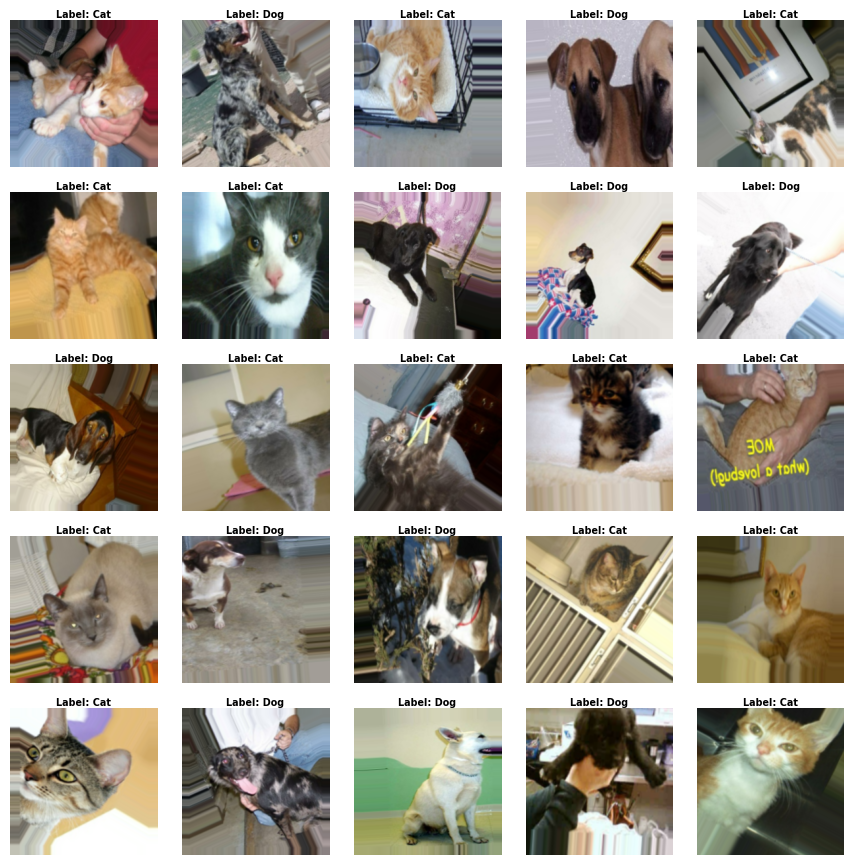

In [ ]:
# Some images from the training dataset after data augmentation
show_images(images, labels, random=False)

## **Model building and training**

Since the convolutional model is trained from scratch, multiple epochs of training are required to achieve the best results. Therefore, the Google Colab TPU is used to speed up the training process.

In [ ]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
def base_cnn(filters=32, dropout_rate=0.1, name=None):
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2),
      tf.keras.layers.Dropout(dropout_rate)
  ], name=name)


def build_model(input_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      base_cnn(filters=32, name="block_conv_1"),
      base_cnn(filters=64, name="block_conv_2"),
      base_cnn(filters=128, name="block_conv_3"),
      base_cnn(filters=256, name="block_conv_4"),
      base_cnn(filters=512, name="block_conv_5"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])

In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = build_model(new_size)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(0.001),
      loss="binary_crossentropy",
      metrics=["accuracy"],
      steps_per_execution=50
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_conv_1 (Sequential)   (None, 112, 112, 32)      10400     
                                                                 
 block_conv_2 (Sequential)   (None, 56, 56, 64)        55936     
                                                                 
 block_conv_3 (Sequential)   (None, 28, 28, 128)       222464    
                                                                 
 block_conv_4 (Sequential)   (None, 14, 14, 256)       887296    
                                                                 
 block_conv_5 (Sequential)   (None, 7, 7, 512)         3544064   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# Necessary libraries to plot the model architecture on the Colab TPU
!pip install pydot graphviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.4 MB/s eta 0:00:00


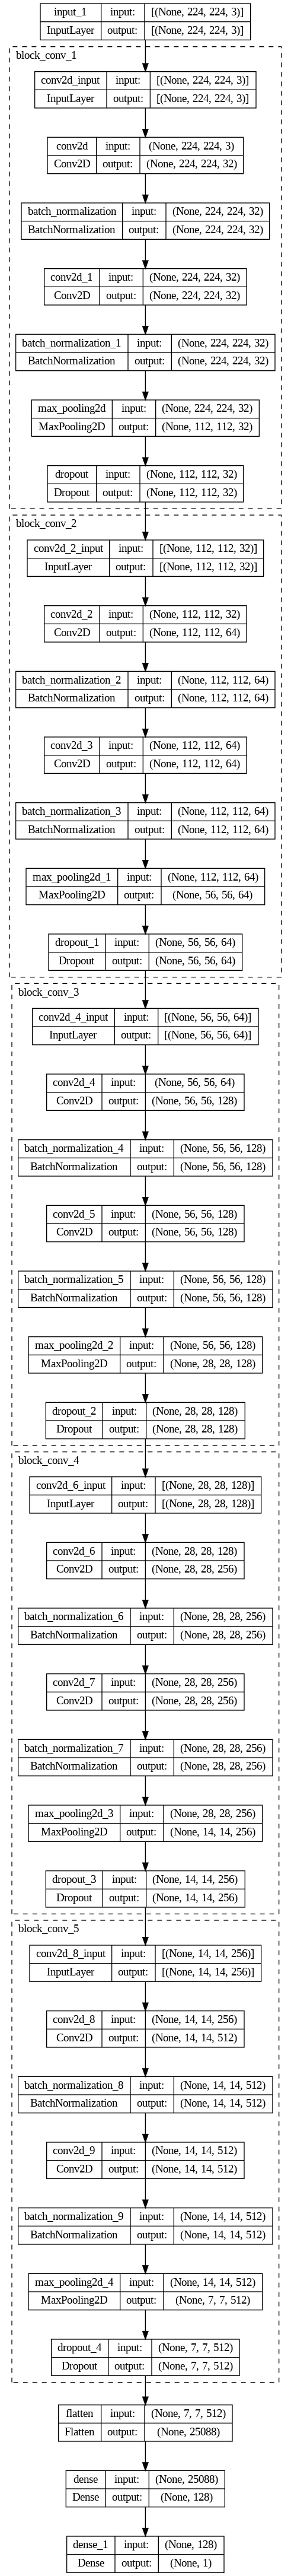

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
# Callback to stop training early if validation accuracy does not improve for 7 epochs
patience = 7
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/100
146/146 [==============================] - 96s 656ms/step - loss: 1.2820 - accuracy: 0.5594 - val_loss: 0.7158 - val_accuracy: 0.5099
Epoch 2/100
146/146 [==============================] - 22s 148ms/step - loss: 0.6346 - accuracy: 0.6379 - val_loss: 0.7125 - val_accuracy: 0.5471
Epoch 3/100
146/146 [==============================] - 21s 147ms/step - loss: 0.6150 - accuracy: 0.6595 - val_loss: 0.6778 - val_accuracy: 0.5886
Epoch 4/100
146/146 [==============================] - 22s 148ms/step - loss: 0.6003 - accuracy: 0.6677 - val_loss: 0.6474 - val_accuracy: 0.6468
Epoch 5/100
146/146 [==============================] - 22s 151ms/step - loss: 0.5879 - accuracy: 0.6757 - val_loss: 0.6393 - val_accuracy: 0.6535
Epoch 6/100
146/146 [==============================] - 22s 153ms/step - loss: 0.5981 - accuracy: 0.6772 - val_loss: 0.7627 - val_accuracy: 0.5583
Epoch 7/100
146/146 [==============================] - 21s 143ms/step - loss: 0.5776 - accuracy: 0.6897 - val_loss: 0.6592 -

**Save the model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/BinaryImageClassification_CNN_CatsVsDogs.keras"
model.save(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.07269887626171112, 0.9698548913002014]
[0.07664328813552856, 0.97463458776474]


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.4 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=True):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

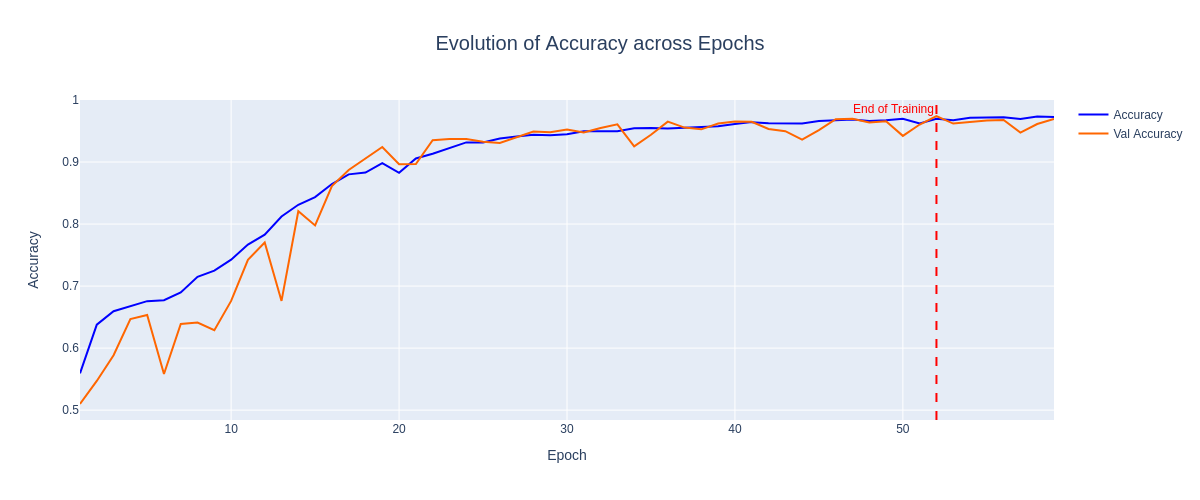

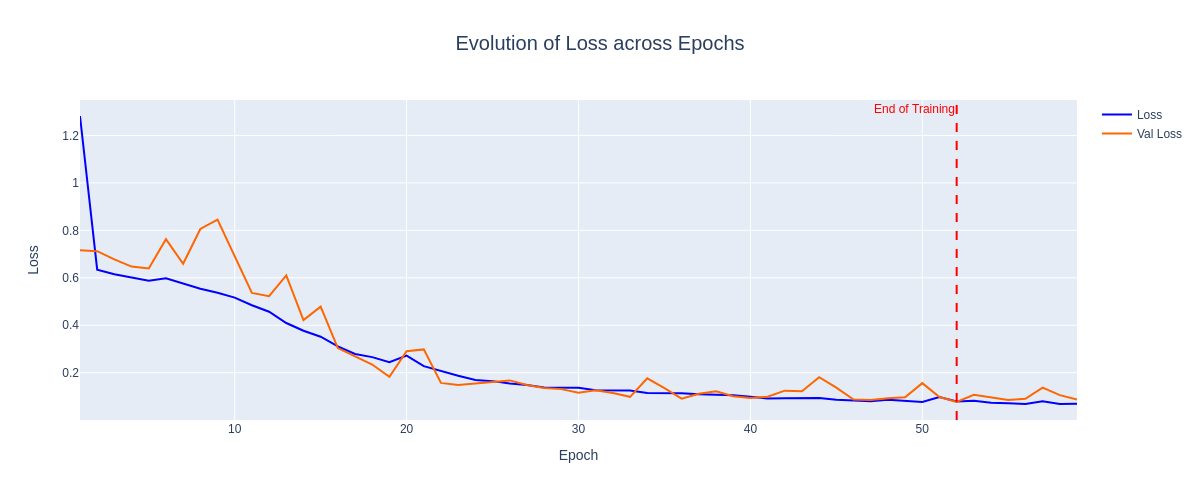

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0).flatten()
labels_test_pred = (labels_test_pred >= 0.5).astype(np.int32)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred)}")

Accuracy: 0.9746345657781599
F1 Score: 0.975396163469558


Frequency per Label: [2280 2372] 



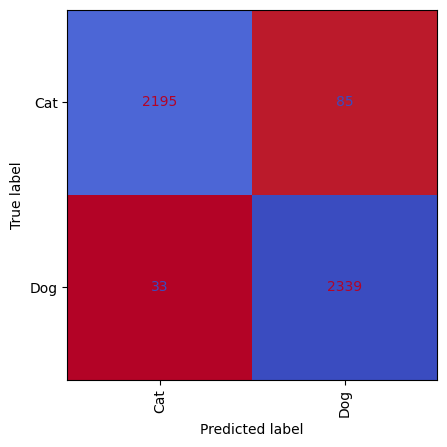

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

It can be seen that the test dataset is approximately balanced, with the ``Dog`` class having only 92 more records. Additionally, the model makes more errors when predicting the ``Cat`` class, likely due to this slight imbalance.

### **Evaluation on the Oxford-IIIT Pet Dataset**

In [ ]:
(train_dataset_oxford, test_dataset_oxford), info = tfds.load(
    "oxford_iiit_pet",
    split=["train", "test"],
    as_supervised=False,
    with_info=True
)

info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.LN09JX_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.LN09JX_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpzobadru5tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [ ]:
def preprocessing_oxford(dic):
  image = tf.image.resize(dic["image"], size=new_size[:-1]) / 255
  label = dic["species"]
  return image, label

In [ ]:
train_dataset_oxford = (
    train_dataset_oxford.
    map(preprocessing_oxford, num_parallel_calls=AUTOTUNE).
    batch(batch_size)
)

test_dataset_oxford = (
    test_dataset_oxford.
    map(preprocessing_oxford, num_parallel_calls=AUTOTUNE).
    batch(batch_size)
)

In [ ]:
print(model.evaluate(train_dataset_oxford, verbose=0))
print(model.evaluate(test_dataset_oxford, verbose=0))

[0.1421518623828888, 0.945652186870575]
[0.13824473321437836, 0.956663966178894]


It is evident that the model's generalization ability is strong even with datasets not used during training, such as the Oxford-IIIT Pet dataset, which also contains images of dogs and cats. The model achieves an accuracy of over **94%** in these cases.

## **Predictions with the trained model**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

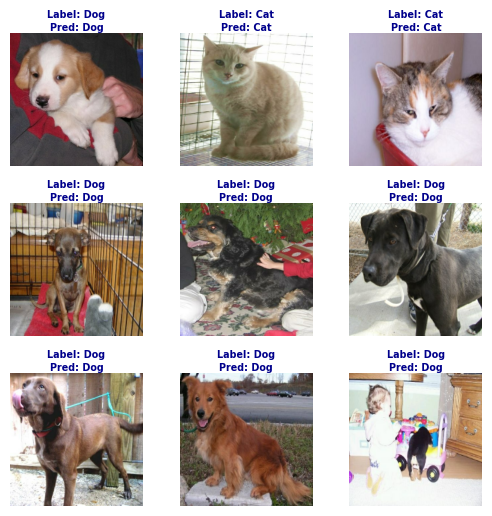

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

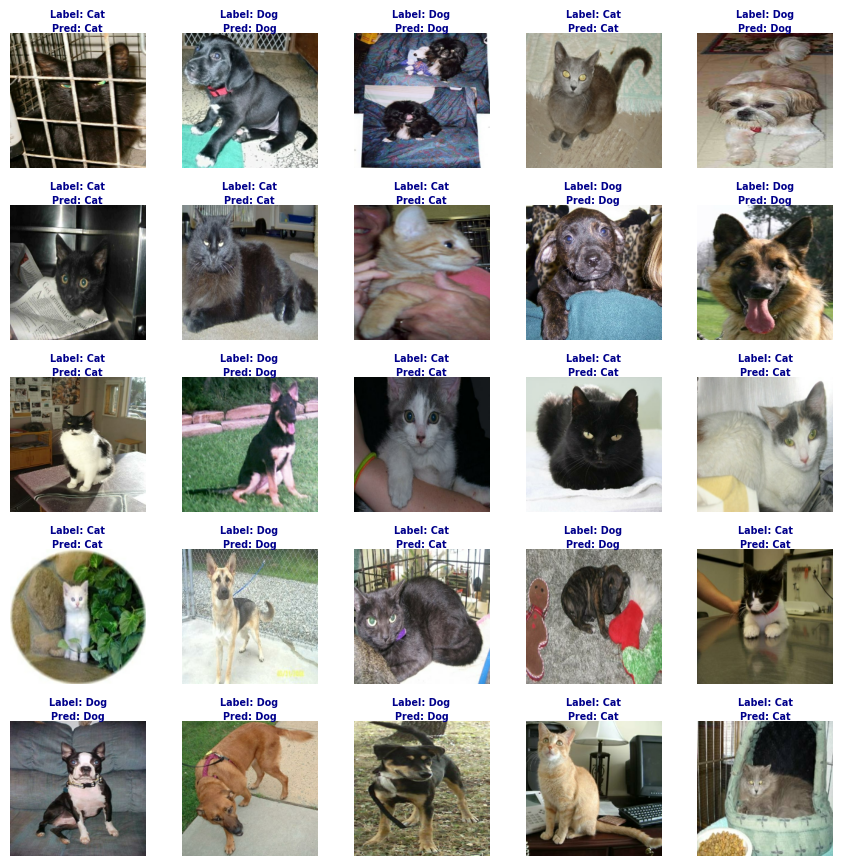

In [ ]:
show_images(
    images_test, labels_test, labels_test_pred,
    save=True, path="BinaryImageClassification_CNN_CatsVsDogs.png"
)

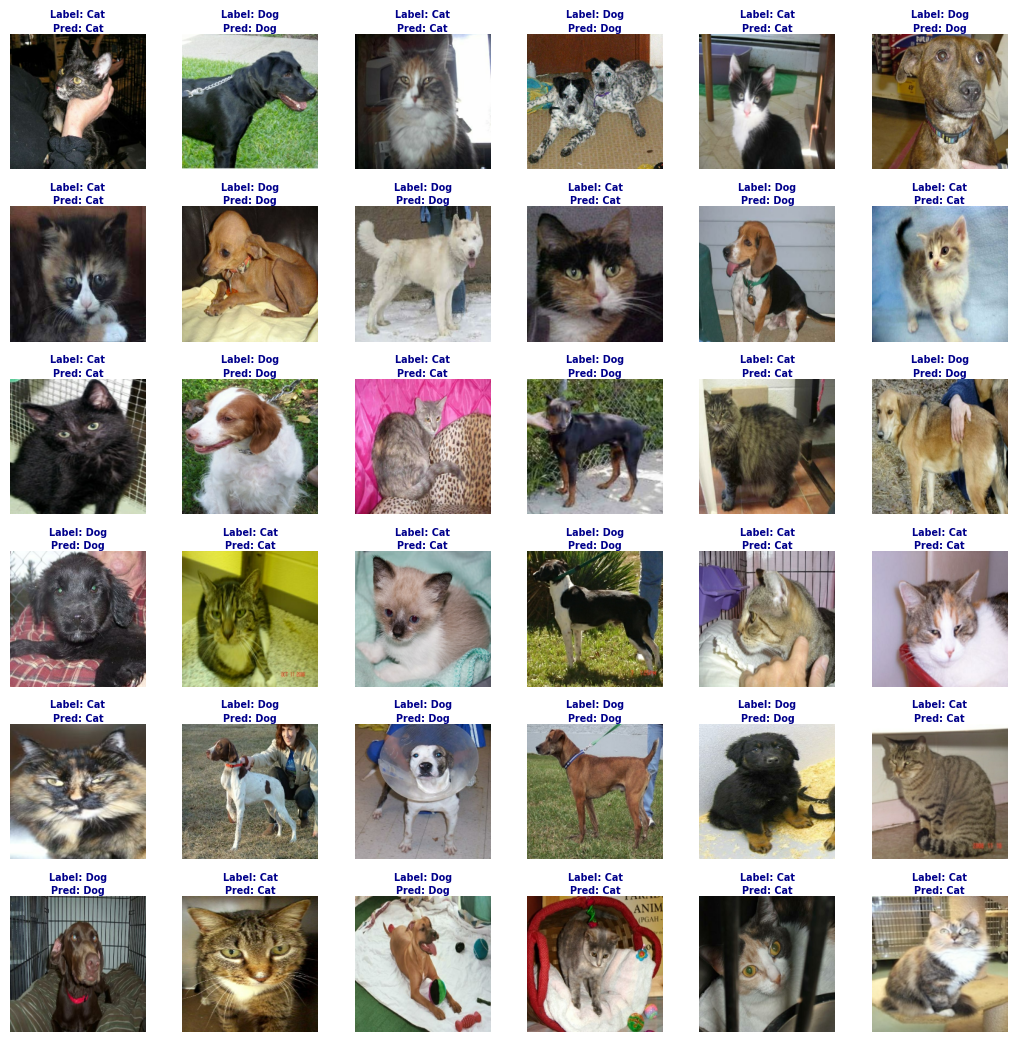

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=36)

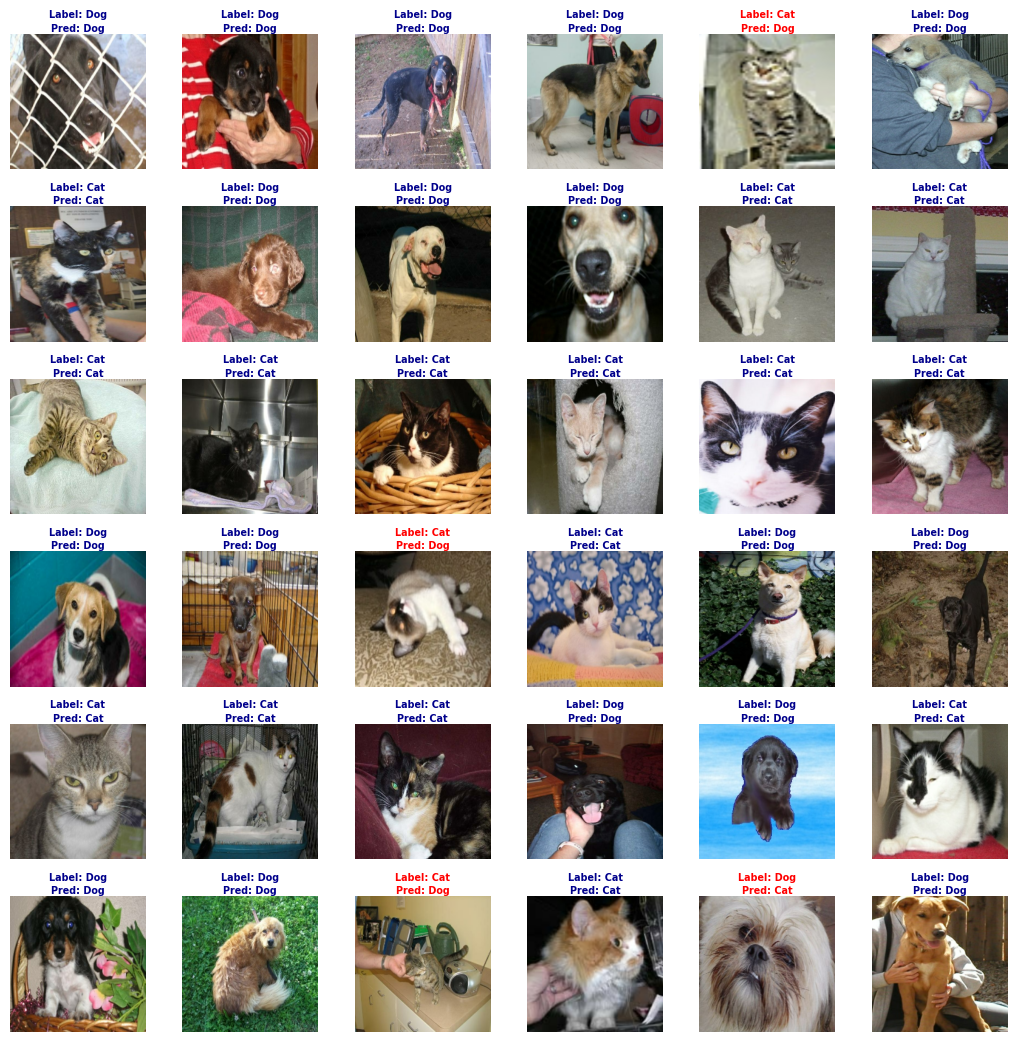

In [ ]:
# The image below shows some incorrect predictions
show_images(images_test, labels_test, labels_test_pred, num_examples=36)

**Conclusion:** The model achieved an accuracy of **96.99%** on the training dataset and **97.46%** on the test dataset, along with an F1 score of **97.54%**. These results demonstrate that the model effectively classifies images of dogs and cats, despite being trained from scratch. Moreover, the balance between precision and recall is notable, as the F1 score is very close to the accuracy in the evaluation. No overfitting was observed, thanks to data augmentation, the model's dropout layers, and the use of early stopping callbacks. If training had continued for more epochs, the accuracy on the training set would likely have reached 100%, while the accuracy on the test set might have started to decline or stabilize. It is also important to note that the model has good generalization capability, even with other datasets not included in the training, such as the Oxford-IIIT Pet dataset, where it achieved accuracies above **94%** in both the training and test sets. To achieve even better results, it is advisable to use transfer learning and/or fine-tune cutting-edge models in the field of computer vision, such as Vision Transformers and their derivatives.